<AxesSubplot:>

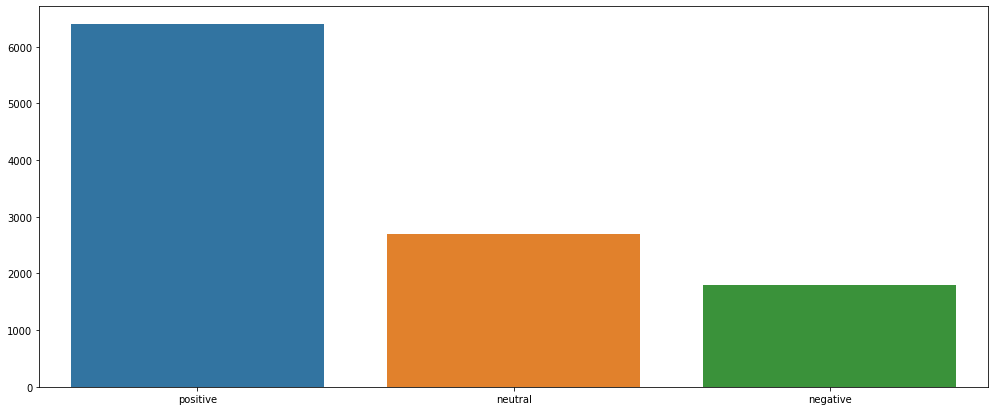

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
my_dict = {'positive': 6395, 'neutral': 2690, 'negative': 1794}
my_dict2 = {'positive':6395,'neutral':1345,'negative':598}

label_1 = {'unrelate':24850, 'relate':8338}
fig, ax = plt.subplots(figsize=(17, 7))
keys = list(my_dict.keys())
# get values in the same order as keys, and parse percentage values
vals = [int(my_dict[k]) for k in keys]
sns.barplot(x=keys, y=vals )

In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import pandas as pd
import torch
import torch.nn as nn
import os
import matplotlib.pyplot as plt
import copy
import torch.optim as optim
import random
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel, AdamW, get_linear_schedule_with_warmup,AutoModelForSequenceClassification
from datasets import load_dataset, load_metric
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, TensorDataset, DataLoader
from underthesea import word_tokenize
import re
#Thay biểu cảm bằng word
from emot.emo_unicode import UNICODE_EMOJI
from emot.emo_unicode import EMOTICONS_EMO
import os
import warnings
from transformers import BertForSequenceClassification, AdamW,RobertaForSequenceClassification,AutoModelForSequenceClassification

warnings.filterwarnings('ignore')
#os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Data Preprocessing

In [7]:
from vncorenlp import VnCoreNLP
annotator = VnCoreNLP(r"C:\Users\Admin\Desktop\Code\DoAn\VnCoreNLP\VnCoreNLP-1.1.1.jar", annotators="wseg", max_heap_size='-Xmx2g') 
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")
def tokenizer_underthesea(text):
    return word_tokenize(text, format="text")
def tokenizer_vncoreNLP(text):
    word_segmented_text = annotator.tokenize(text) 
    result = ''
    for sentences in word_segmented_text:
        result = result + ' '.join(i for i in sentences)
        result = result+' '
    return result.strip()
# Thay thế tiền bằng 'giá' và hag_tag
def replace_money(text):
    for i in range(len(text.split(" "))):
        dict = {}
        dict['k'] = str(text.split(" ")[i]).find('k')
        dict['d'] = str(text.split(" ")[i]).find('d')
        dict['đ'] = str(text.split(" ")[i]).find('đ')
        dict['$'] = str(text.split(" ")[i]).find('$')
        
        for j in dict:
            if dict[j]==-1:
                continue
            if len(text.split(" ")[i])>1 and text.split(" ")[i][dict[j]-1].isdigit()==True:      
                text = text.replace(text.split(" ")[i],'giá tiền')
                break
    return text

def replace_hagtag(text):
    for i in range(len(text.split(" "))):
        if len(text.split(" ")[i])<2:
            continue
        if text.split(" ")[i][0] == '#' and text.split(" ")[i][1] != '#':
            text = text.replace(text.split(" ")[i],'hagtag')
    return text
def remove_character(text):
    # Xóa tất cả dấu chấm, phẩy, chấm phẩy, chấm thang, ... trong câu
    text = text.replace('"', " ").replace(";", " ").replace("“", " ") \
        .replace(":", " ").replace("”", " ").replace('•','') \
        .replace("'", " ").replace("~","") \
        .replace("-", " ").replace("_"," ").replace("*"," ").replace("@"," ").replace("|"," ")\
        .replace("%"," ").replace("^"," ").replace("&"," ").replace("("," ").replace(")"," ")\
        .replace("<"," ").replace(">"," ").replace("+"," ").replace("-"," ").replace("/"," ").replace("_"," ").replace("["," ").replace("]"," ").replace("#", " ").replace("$","")
    text = text.strip().lower()
    return text

def replace_emoticon(text):
    for i, j in EMOTICONS_EMO.items():
        text = text.replace(i, ' ')
    return text

def replace_emoji(text):
    for i, j in UNICODE_EMOJI.items():
        text = text.replace(i, ' ')
    return text

# #Xoa link trong cau
# def delete_link(text):
#     return re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)

def count_word(text):
    return len(tokenizer.encode(text, add_special_tokens = False))

dict_map = {
    "òa": "oà",
    "Òa": "Oà",
    "ÒA": "OÀ",
    "óa": "oá",
    "Óa": "Oá",
    "ÓA": "OÁ",
    "ỏa": "oả",
    "Ỏa": "Oả",
    "ỎA": "OẢ",
    "õa": "oã",
    "Õa": "Oã",
    "ÕA": "OÃ",
    "ọa": "oạ",
    "Ọa": "Oạ",
    "ỌA": "OẠ",
    "òe": "oè",
    "Òe": "Oè",
    "ÒE": "OÈ",
    "óe": "oé",
    "Óe": "Oé",
    "ÓE": "OÉ",
    "ỏe": "oẻ",
    "Ỏe": "Oẻ",
    "ỎE": "OẺ",
    "õe": "oẽ",
    "Õe": "Oẽ",
    "ÕE": "OẼ",
    "ọe": "oẹ",
    "Ọe": "Oẹ",
    "ỌE": "OẸ",
    "ùy": "uỳ",
    "Ùy": "Uỳ",
    "ÙY": "UỲ",
    "úy": "uý",
    "Úy": "Uý",
    "ÚY": "UÝ",
    "ủy": "uỷ",
    "Ủy": "Uỷ",
    "ỦY": "UỶ",
    "ũy": "uỹ",
    "Ũy": "Uỹ",
    "ŨY": "UỸ",
    "ụy": "uỵ",
    "Ụy": "Uỵ",
    "ỤY": "UỴ",
    }

def replace_all(text):
    for i, j in dict_map.items():
        text = text.replace(i, j)
    return text

def remove_space(text):
    return ' '.join(text.split())


dict_word_match = {"mik":"mình",
                " k ":" không ",
                " ko ":" không ",
                "size":"kích cỡ",
                "nhug":"nhưng",
                "nhg":"nhưng",
                "bik":"biết",
                "hjhj":"hihi",
                "sp":"sản phẩm",
                "k ":"không ",
                "siu":"siêu",
                "qc":"quảng cáo",
                "mk":"mình",
                " mh ":" mình ",
                "cx":"cũng",
                "xog":"xong",
                'ship': 'vận chuyển',
                'shop': 'cửa hàng',
                ' m ': ' mình ',
                'mik': 'mình',
                'khong': 'không',
                'khg': 'không',
                'tl': 'trả lời',
                'rep': 'trả lời',
                ' r ': ' rồi ',
                'fb': 'facebook',
                'face': 'faceook',
                'thanks': 'cảm ơn',
                'thank': 'cảm ơn',
                'tks': 'cảm ơn',
                'tk': 'cảm ơn',
                'ok': 'tốt',
                'oki': 'tốt',
                'okie': 'tốt',
                'sp': 'sản phẩm',
                'dc': 'được',
                'vs': 'với',
                'đt': 'điện thoại',
                'thjk': 'thích',
                'thik': 'thích',
                'qá': 'quá',
                'trể': 'trễ',
                'bgjo': 'bao giờ',
                ' h ': ' giờ ',
                'qa': 'quá',
                'dep': 'đẹp',
                'xau': 'xấu',
                'ib': 'nhắn tin',
                'cute': 'dễ thương',
                'sz': 'size',
                'good': 'tốt',
                'god': 'tốt',
                'bt': 'bình thường',
                'nvay':'như vậy'
                            }
def replace_all_1(text):
    for i, j in dict_word_match.items():
        text = text.replace(i, j)
    return text

def remove_long_word(text):
    return re.sub(r'([A-Z])\1+', lambda m: m.group(1).lower(), text, flags=re.IGNORECASE)



Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [14]:
data = pd.read_csv(r'C:\Users\Admin\Desktop\Code\DoAn\hackathon.csv')
data

,Text,giải_trí,lưu_trú,nhà_hàng,ăn_uống,di_chuyển,mua_sắm
0,"bánh rất nhiều tôm to , tôm giòn nằm chễm_chệ ...",0,0,0,5,0,0
1,đi quy nhơn cứ lo không có piza ăn nhưng nhờ c...,0,0,0,5,0,0
2,"các món ăn_ở đây không có gì đặc_sắc , có_lẽ n...",0,0,1,1,0,0
3,"lần thứ 2 quay lại đây , vì giới_thiệu quán cà...",0,0,0,2,0,0
4,rất khuyên bạn nên ghé thăm quán bar thể_thao này,3,0,0,0,0,0
...,...,...,...,...,...,...,...
3683,"ngon , giá hợp_lý không thích món gà rán vì ăn...",0,0,0,5,0,0
3684,người lái_xe đến sớm để đợi tôi . tôi yên_tâm ...,5,0,0,0,0,0
3685,"phòng đẹp , sạch_sẽ đầy_đủ tiện_nghi , nằm tro...",0,5,0,0,0,0
3686,nói_chung là rất nhàm_chán cới kiểu làm du_lịc...,1,0,0,0,0,0


# Aspect Detection

## Tạo data Relate và Unrelate

In [18]:
def make_column(name_column):
    column = []
    for i in range(len(data)):
        for j in range(0,6):
            column.append(data[name_column][i])
    return column
text1 = []
for i in range(len(data)):
    aspect = ['giải_trí','lưu_trú','nhà_hàng','ăn_uống','di_chuyển','mua_sắm']
    text1.extend(aspect)
text = make_column('Text')
giai_tri = make_column('giải_trí')
luu_tru = make_column('lưu_trú')
nha_hang = make_column('nhà_hàng')
an_uong = make_column('ăn_uống')
di_chuyen = make_column('di_chuyển')
mua_sam = make_column('mua_sắm')


In [22]:
data = pd.DataFrame()
data['Text'] = text
data['Text1'] = text1
data['giải_trí'] = giai_tri
data['lưu_trú'] = luu_tru
data['nhà_hàng'] = nha_hang
data['ăn_uống'] = an_uong
data['di_chuyển'] = di_chuyen
data['mua_sắm'] = mua_sam
data

,Text,Text1,giải_trí,lưu_trú,nhà_hàng,ăn_uống,di_chuyển,mua_sắm
0,"bánh rất nhiều tôm to , tôm giòn nằm chễm_chệ ...",giải_trí,0,0,0,5,0,0
1,"bánh rất nhiều tôm to , tôm giòn nằm chễm_chệ ...",lưu_trú,0,0,0,5,0,0
2,"bánh rất nhiều tôm to , tôm giòn nằm chễm_chệ ...",nhà_hàng,0,0,0,5,0,0
3,"bánh rất nhiều tôm to , tôm giòn nằm chễm_chệ ...",ăn_uống,0,0,0,5,0,0
4,"bánh rất nhiều tôm to , tôm giòn nằm chễm_chệ ...",di_chuyển,0,0,0,5,0,0
...,...,...,...,...,...,...,...,...
22123,"lần đầu trải_nghiệm sbay phù_cát , các bạn nhâ...",lưu_trú,0,0,0,0,4,0
22124,"lần đầu trải_nghiệm sbay phù_cát , các bạn nhâ...",nhà_hàng,0,0,0,0,4,0
22125,"lần đầu trải_nghiệm sbay phù_cát , các bạn nhâ...",ăn_uống,0,0,0,0,4,0
22126,"lần đầu trải_nghiệm sbay phù_cát , các bạn nhâ...",di_chuyển,0,0,0,0,4,0


In [24]:
#Check liên quan hay ko liên quan
label1 = []
for i in range(len(data)):
    if data[data['Text1'][i]][i] != 0:
        label1.append('relate')
    else:
        label1.append('unrelate')
data['Label1'] = label1

In [ ]:
#Loại bỏ các câu dài
data['Pair'] = data['Text']+" "+data['Text1']
data['Count'] = data['Pair'].apply(count_word)
data = data[(data['Count']<=254)&(data['Count']>0)].reset_index(drop=True)
data

## Code model

In [60]:
data = pd.read_csv('data_full_hackathon.csv')
data

,Text,Text1,giải_trí,lưu_trú,nhà_hàng,ăn_uống,di_chuyển,mua_sắm,Label1,Pair,Count
0,"bánh rất nhiều tôm to , tôm giòn nằm chễm_chệ ...",giải_trí,0,0,0,5,0,0,unrelate,"bánh rất nhiều tôm to , tôm giòn nằm chễm_chệ ...",98
1,"bánh rất nhiều tôm to , tôm giòn nằm chễm_chệ ...",lưu_trú,0,0,0,5,0,0,unrelate,"bánh rất nhiều tôm to , tôm giòn nằm chễm_chệ ...",98
2,"bánh rất nhiều tôm to , tôm giòn nằm chễm_chệ ...",nhà_hàng,0,0,0,5,0,0,unrelate,"bánh rất nhiều tôm to , tôm giòn nằm chễm_chệ ...",98
3,"bánh rất nhiều tôm to , tôm giòn nằm chễm_chệ ...",ăn_uống,0,0,0,5,0,0,relate,"bánh rất nhiều tôm to , tôm giòn nằm chễm_chệ ...",98
4,"bánh rất nhiều tôm to , tôm giòn nằm chễm_chệ ...",di_chuyển,0,0,0,5,0,0,unrelate,"bánh rất nhiều tôm to , tôm giòn nằm chễm_chệ ...",98
...,...,...,...,...,...,...,...,...,...,...,...
21973,"lần đầu trải_nghiệm sbay phù_cát , các bạn nhâ...",lưu_trú,0,0,0,0,4,0,unrelate,"lần đầu trải_nghiệm sbay phù_cát , các bạn nhâ...",18
21974,"lần đầu trải_nghiệm sbay phù_cát , các bạn nhâ...",nhà_hàng,0,0,0,0,4,0,unrelate,"lần đầu trải_nghiệm sbay phù_cát , các bạn nhâ...",18
21975,"lần đầu trải_nghiệm sbay phù_cát , các bạn nhâ...",ăn_uống,0,0,0,0,4,0,unrelate,"lần đầu trải_nghiệm sbay phù_cát , các bạn nhâ...",18
21976,"lần đầu trải_nghiệm sbay phù_cát , các bạn nhâ...",di_chuyển,0,0,0,0,4,0,relate,"lần đầu trải_nghiệm sbay phù_cát , các bạn nhâ...",18


In [43]:
data_train = data[:16362]
data_val = data[16362:].reset_index(drop=True)

In [42]:
tokenizer = AutoTokenizer.from_pretrained('vinai/phobert-base')  
class CustomDataset(Dataset):

    def __init__(self, data, maxlen, with_labels=True,tokenizer=tokenizer):

        self.data = data  # pandas dataframe
        #Initialize the tokenizer
        self.tokenizer = tokenizer

        self.maxlen = maxlen
        self.with_labels = with_labels 
        self.dict_label = {'relate':1,'unrelate':0}
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):

        # Selecting sentence1 and sentence2 at the specified index in the data frame
        sent = str(self.data.loc[index, 'Text'])
        sent1 = str(self.data.loc[index, 'Text1'])

        # Tokenize the pair of sentences to get token ids, attention masks and token type ids
        encoded_pair = self.tokenizer(sent1, sent, 
                                      padding='max_length',  # Pad to max_length
                                      truncation=True,  # Truncate to max_length
                                      max_length=self.maxlen,  
                                      return_tensors='pt')  # Return torch.Tensor objects
        
        token_ids = encoded_pair['input_ids'].squeeze(0)  # tensor of token ids
        attn_masks = encoded_pair['attention_mask'].squeeze(0)  # binary tensor with "0" for padded values and "1" for the other values
        token_type_ids = encoded_pair['token_type_ids'].squeeze(0)  # binary tensor with "0" for the 1st sentence tokens & "1" for the 2nd sentence tokens

        if self.with_labels:  # True if the dataset has labels
            label = self.data.loc[index, 'Label1']
            label = self.dict_label[label]
            return token_ids, attn_masks, token_type_ids, label  
        else:
            return token_ids, attn_masks, token_type_ids

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [44]:
# Creating instances of training and validation set
print("Reading training data...")
train_set = CustomDataset(data=data_train, maxlen=258, tokenizer=tokenizer)
print("Reading validation data...")
val_set = CustomDataset(data=data_val, maxlen=258, tokenizer=tokenizer)
# Creating instances of training and validation dataloaders
train_loader = DataLoader(train_set, batch_size=16)
val_loader = DataLoader(val_set, batch_size=16)

Reading training data...
Reading validation data...


In [55]:
class Model_Detection(nn.Module):
    def __init__(self):
        super(Model_Detection, self).__init__()
        self.roberta = AutoModel.from_pretrained("vinai/phobert-base")
        self.classifier = torch.nn.Linear(768, 2)
        self.dropout = torch.nn.Dropout(0.1)
    def forward(self, pair_token_ids, token_type_ids, attention_mask):
        output_1 = self.roberta(input_ids=pair_token_ids,token_type_ids=token_type_ids,attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Model_Detection().to(device=device)

Some weights of the model checkpoint at vinai/phobert-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.decoder.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [56]:
param_optimizer = list(model.named_parameters())
optimizer = AdamW(model.parameters(),
                      lr=1e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

#134,999,810    135,590,402     137,359,874

The model has 134,999,810 trainable parameters


In [57]:
criterion = nn.CrossEntropyLoss()

In [58]:
import time
from sklearn.metrics import f1_score, accuracy_score
from tqdm.notebook import tqdm
from tqdm import tqdm_notebook


EPOCHS = 6

train_loss = []
train_acc = []
train_f1 = []
val_loss = []
val_acc = []
val_f1 = []
for epoch in range(EPOCHS):
    print('======== Epoch {:} / {:} ========'.format(epoch + 1, EPOCHS))
    print('Training...')
    start = time.time()
    model.train()
    total_train_loss = 0
    total_train_acc  = 0
    total_train_f1 = 0
    f1_full_train = [0,0]
    for step, (pair_token, mask, seg, y) in tqdm_notebook(enumerate(train_loader)): 
        pair_token_ids = pair_token.to(device)
        mask_ids = mask.to(device)
        seg_ids = seg.to(device)
        labels = y.to(device).long()
        optimizer.zero_grad()
        # prediction = model(pair_token_ids, mask_ids, seg_ids)
        prediction = model(pair_token_ids, 
                                token_type_ids=seg_ids, 
                                attention_mask=mask_ids
                                )
        loss = criterion(prediction,labels)
        y_pred = torch.log_softmax(prediction, dim=1).argmax(dim=1).cpu().tolist()
        y_true = labels.cpu().tolist()

        acc = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average='macro')
        f1_full_train = f1_full_train + f1_score(y_true, y_pred, average=None)


        loss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        total_train_loss += loss.item()
        total_train_acc  += acc
        total_train_f1   += f1
    
    print(" Average training loss: {0:.4f}".format(total_train_loss/len(train_loader)))
    print(" Accuracy: {0:.4f}".format(total_train_acc/len(train_loader)))
    print(" F1 score: {0:.4f}".format(total_train_f1/len(train_loader)))
    print(" F1 full: ",f1_full_train/len(train_loader))
    
    train_loss.append(total_train_loss/len(train_loader))
    train_acc.append(total_train_acc/len(train_loader))
    train_f1.append(total_train_f1/len(train_loader))

    print("Running Validation...")
    model.eval()
    total_val_acc  = 0
    total_val_loss = 0
    total_val_f1 = 0
    f1_full_val = [0,0]
    for step, (pair_token, mask, seg, y) in tqdm_notebook(enumerate(val_loader)): 
        pair_token_ids = pair_token.to(device)
        mask_ids = mask.to(device)
        seg_ids = seg.to(device)
        labels = y.to(device).long()
        with torch.no_grad():
            # prediction = model(pair_token_ids, mask_ids, seg_ids)
            prediction = model(pair_token_ids, 
                                token_type_ids=seg_ids, 
                                attention_mask=mask_ids
                                )
            
            loss = criterion(prediction,labels)
            y_pred = torch.log_softmax(prediction, dim=1).argmax(dim=1).cpu().tolist()
            y_true = labels.cpu().tolist()

            acc = accuracy_score(y_true, y_pred)
            f1 = f1_score(y_true, y_pred, average='macro')
            f1_full_val = f1_full_val + f1_score(y_true, y_pred, average=None)
            
            total_val_loss += loss.item()
            total_val_acc  += acc
            total_val_f1   += f1

    print(" Average validation loss: {0:.4f}".format(total_val_loss/len(val_loader)))
    print(" Accuracy: {0:.4f}".format(total_val_acc/len(val_loader)))
    print(" F1 score: {0:.4f}".format(total_val_f1/len(val_loader)))
    print(" F1 full: ",f1_full_val/len(val_loader))
    val_loss.append(total_val_loss/len(val_loader))
    val_acc.append(total_val_acc/len(val_loader))
    val_f1.append(total_val_f1/len(val_loader))
    
    end = time.time()
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))
        

======== Epoch 1 / 6 ========
Training...


0it [00:00, ?it/s]

 Average training loss: 0.3020
 Accuracy: 0.8817
 F1 score: 0.7303
 F1 full:  [0.92964131 0.53105693]
Running Validation...


0it [00:00, ?it/s]

 Average validation loss: 0.2343
 Accuracy: 0.9197
 F1 score: 0.8475
 F1 full:  [0.95127844 0.74381894]
00:05:38.88
======== Epoch 2 / 6 ========
Training...


0it [00:00, ?it/s]

 Average training loss: 0.1870
 Accuracy: 0.9319
 F1 score: 0.8824
 F1 full:  [0.95763328 0.80711782]
Running Validation...


0it [00:00, ?it/s]

 Average validation loss: 0.2047
 Accuracy: 0.9229
 F1 score: 0.8568
 F1 full:  [0.95299891 0.76053227]
00:05:51.37
======== Epoch 3 / 6 ========
Training...


0it [00:00, ?it/s]

 Average training loss: 0.1564
 Accuracy: 0.9438
 F1 score: 0.9028
 F1 full:  [0.96491804 0.8406554 ]
Running Validation...


0it [00:00, ?it/s]

 Average validation loss: 0.2035
 Accuracy: 0.9272
 F1 score: 0.8744
 F1 full:  [0.95482941 0.79395687]
00:05:50.81
======== Epoch 4 / 6 ========
Training...


0it [00:00, ?it/s]

 Average training loss: 0.1286
 Accuracy: 0.9541
 F1 score: 0.9231
 F1 full:  [0.97111123 0.87515293]
Running Validation...


0it [00:00, ?it/s]

 Average validation loss: 0.2070
 Accuracy: 0.9256
 F1 score: 0.8743
 F1 full:  [0.95350359 0.79508651]
00:05:43.86
======== Epoch 5 / 6 ========
Training...


0it [00:00, ?it/s]

 Average training loss: 0.1053
 Accuracy: 0.9635
 F1 score: 0.9383
 F1 full:  [0.97710188 0.89943264]
Running Validation...


0it [00:00, ?it/s]

 Average validation loss: 0.2435
 Accuracy: 0.9272
 F1 score: 0.8729
 F1 full:  [0.95483453 0.79094959]
00:05:44.18
======== Epoch 6 / 6 ========
Training...


0it [00:00, ?it/s]

 Average training loss: 0.0859
 Accuracy: 0.9704
 F1 score: 0.9503
 F1 full:  [0.9813321  0.91929657]
Running Validation...


0it [00:00, ?it/s]

 Average validation loss: 0.2461
 Accuracy: 0.9266
 F1 score: 0.8811
 F1 full:  [0.95365476 0.80847712]
00:05:43.60


In [59]:
torch.save(model.state_dict(), 'Model/AspectDetectionModelBaseDataOrigin88.pt')
